# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
!pip install catboost
!pip install phik

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 7.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
from sklearn.impute import SimpleImputer
import phik
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import f1_score
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.metrics import mean_squared_error
import math
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from time import time
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor

In [3]:
RANDOM_STATE = 12345

In [4]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [5]:
#ProfileReport(df)

In [6]:
df[df.duplicated ()]


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


In [7]:
df = df.drop_duplicates()

In [8]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  object
 1   Price              354365 non-null  int64 
 2   VehicleType        316875 non-null  object
 3   RegistrationYear   354365 non-null  int64 
 4   Gearbox            334532 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              334660 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           321470 non-null  object
 10  Brand              354365 non-null  object
 11  Repaired           283211 non-null  object
 12  DateCreated        354365 non-null  object
 13  NumberOfPictures   354365 non-null  int64 
 14  PostalCode         354365 non-null  int64 
 15  LastSeen           354365 non-null  object
dtypes: int64(7), object(

In [10]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [11]:
def unique_for_data(dataset):
    for column in dataset.columns:
        print(column)
        print(dataset[column].unique())

In [12]:
unique_for_data(df)

DateCrawled
['2016-03-24 11:52:17' '2016-03-24 10:58:45' '2016-03-14 12:52:21' ...
 '2016-03-21 09:50:58' '2016-03-14 17:48:27' '2016-03-19 18:57:12']
Price
[  480 18300  9800 ... 12395 18429 10985]
VehicleType
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
RegistrationYear
[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2290 2500 1930 1001 9450 1944 1943 1934 1938 1688 2800
 1253 1928 1919 5555 5600 1600 2222 1039 9996 1300 8455 1931 

In [13]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [14]:
columns_for_graph = ['Price', 'RegistrationYear','Power', 'Kilometer']

In [15]:
sns.set(rc={'figure.figsize':(20, 8)})

In [16]:
def graphs(dataset):
    for column in columns_for_graph:
        fig, ax = plt.subplots(1, 2)

        sns.histplot(dataset[column], ax=ax[0], color='blue', kde=True)
        ax[0].set_title('Распределение столбца \'{}\' датасета - \'df\''.format(column))

        sns.violinplot(dataset[column], ax=ax[1], color='orange')
        ax[1].set_title('Violinplot для \'{}\'  датасета - \'df\''.format(column))

        plt.show()

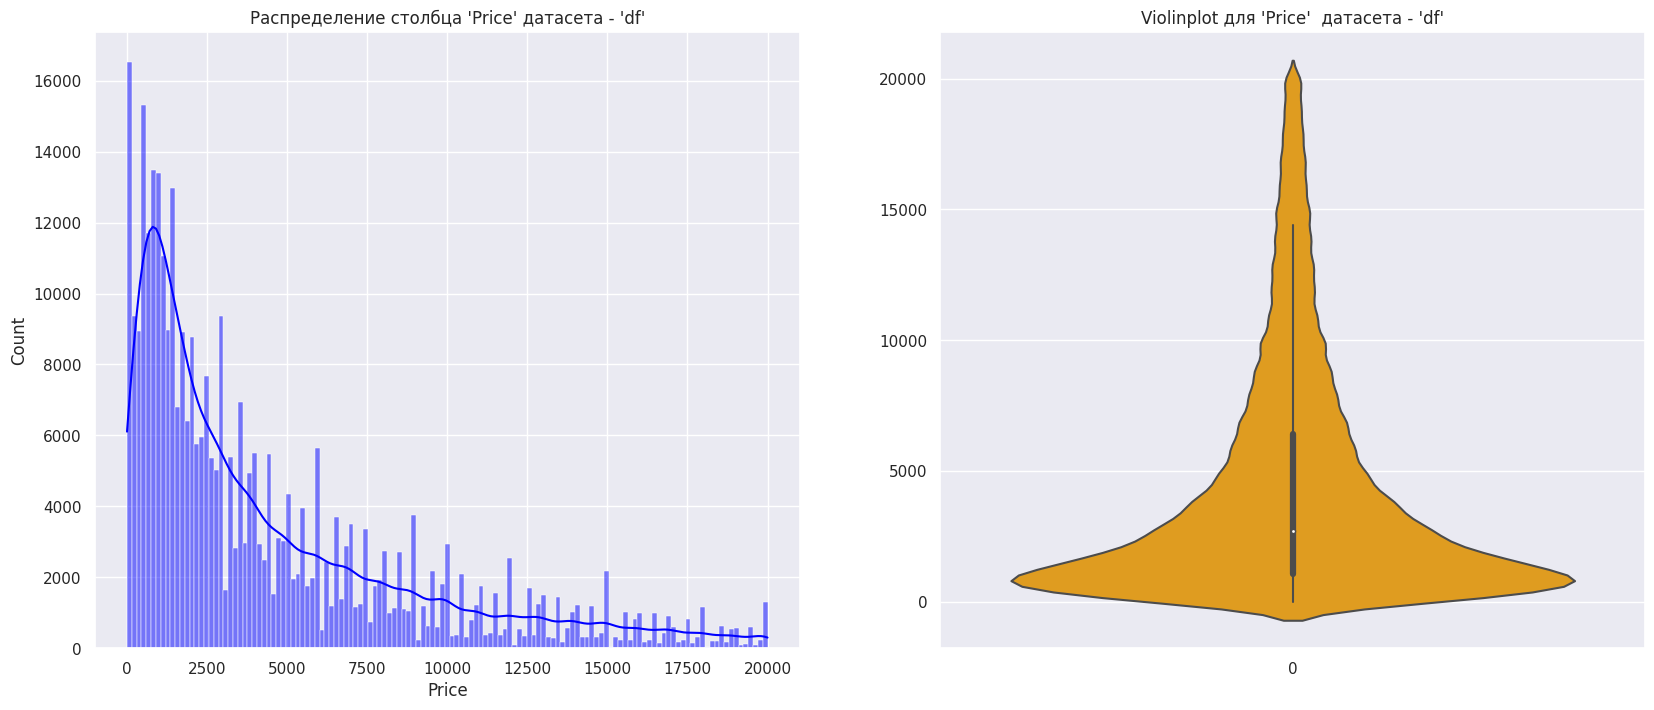

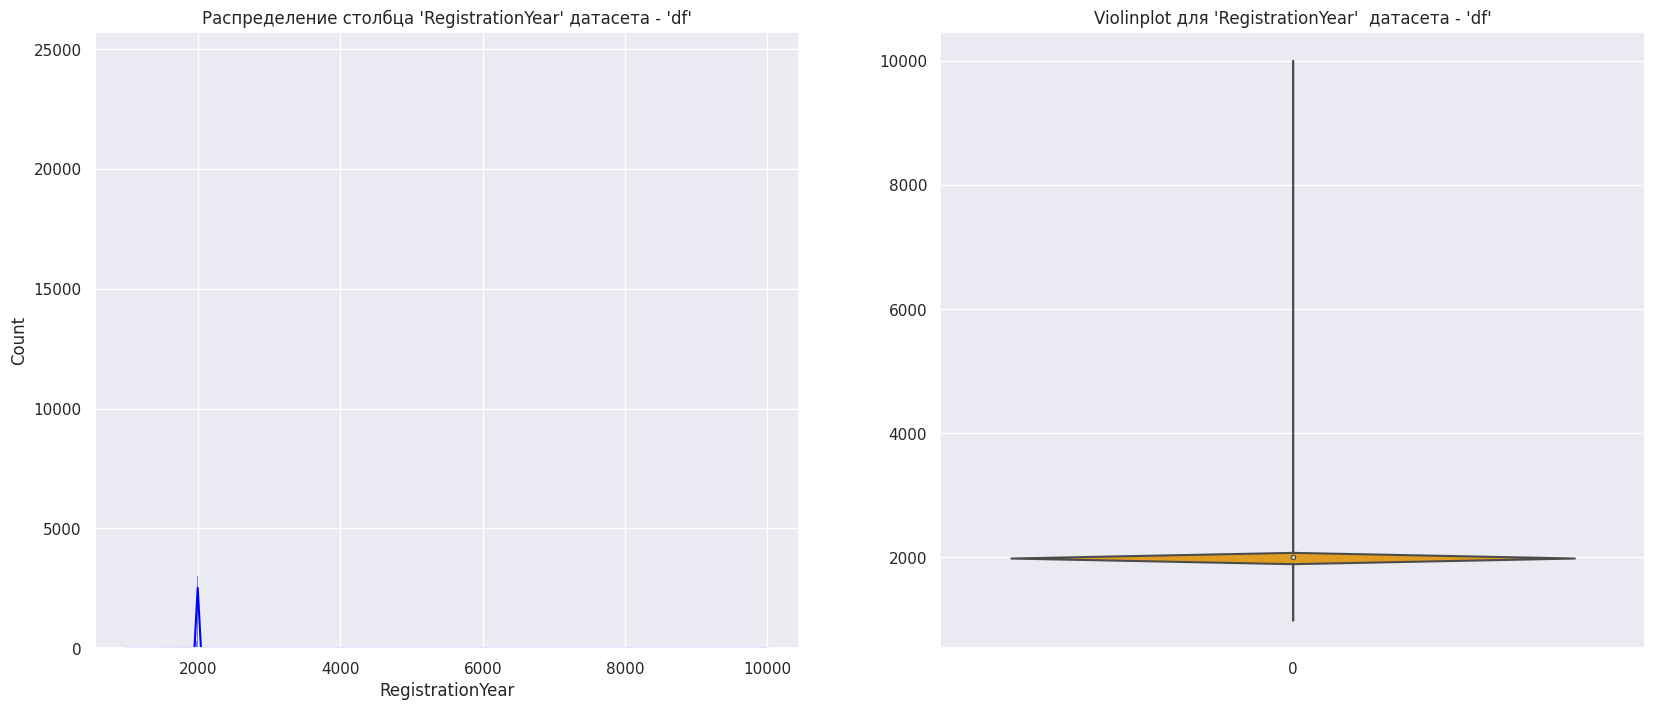

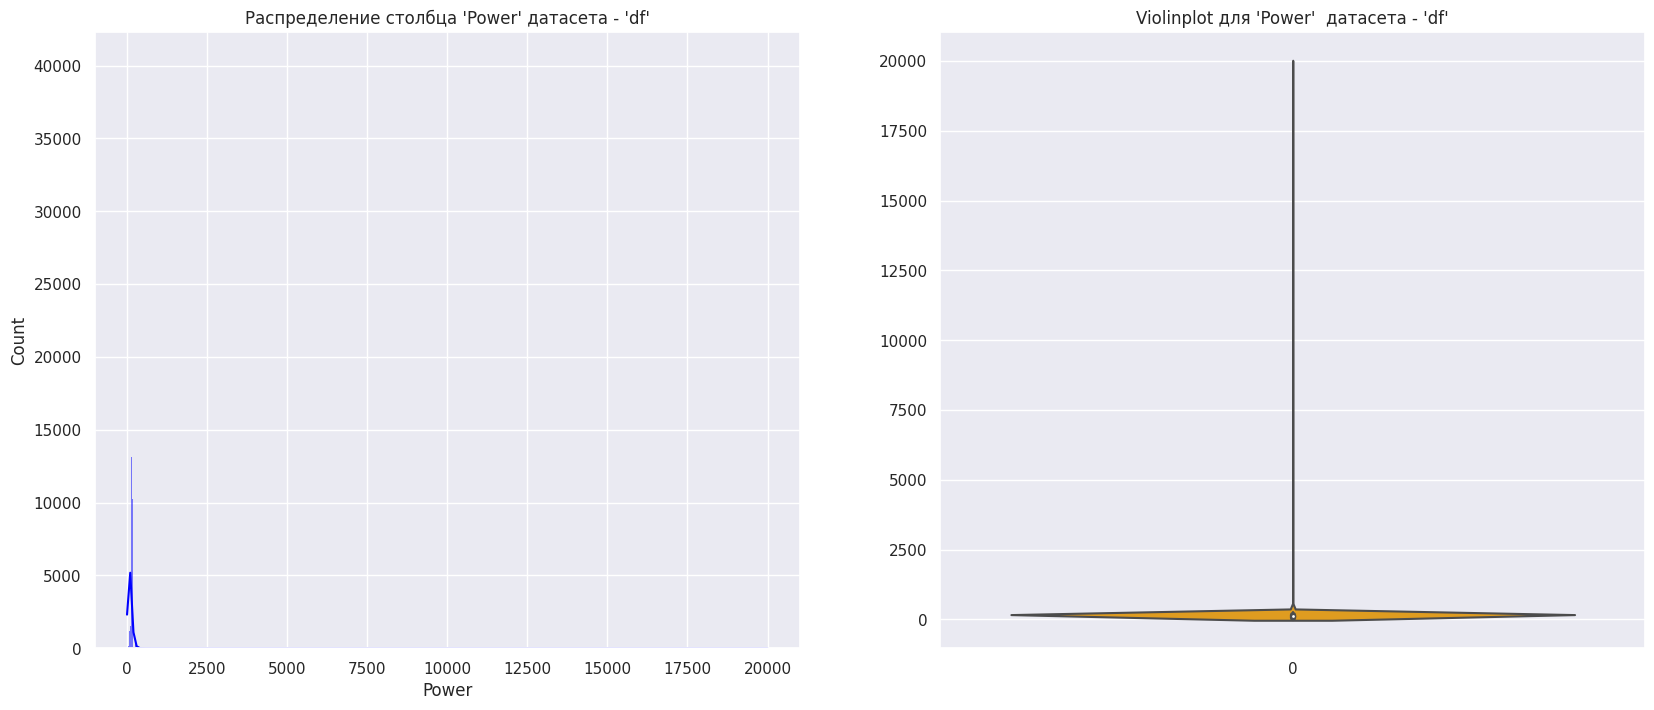

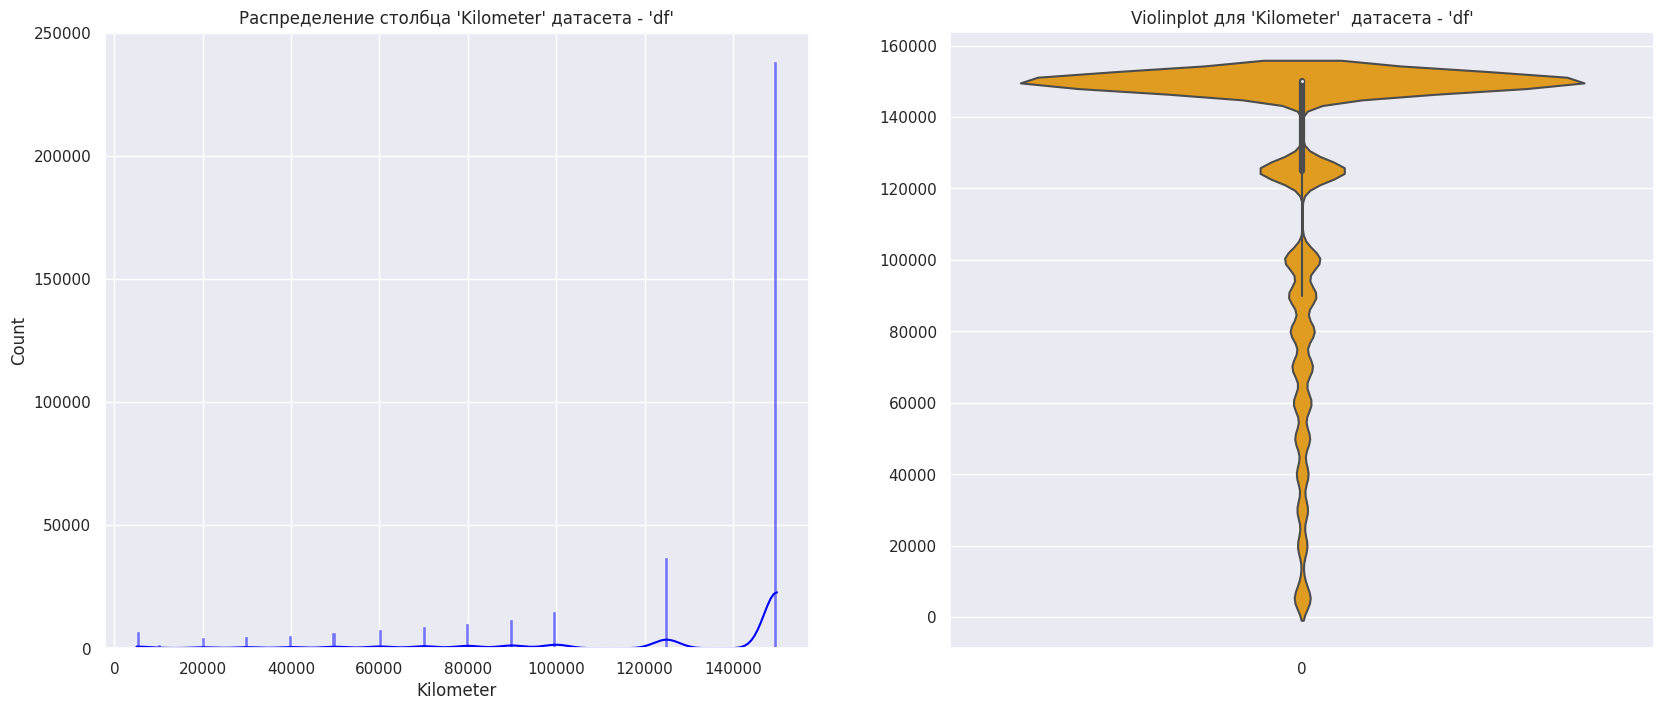

In [17]:
graphs(df)

In [18]:
categorial_columns = ['VehicleType', 'Gearbox', 'FuelType', 'Repaired', 'Brand' ]

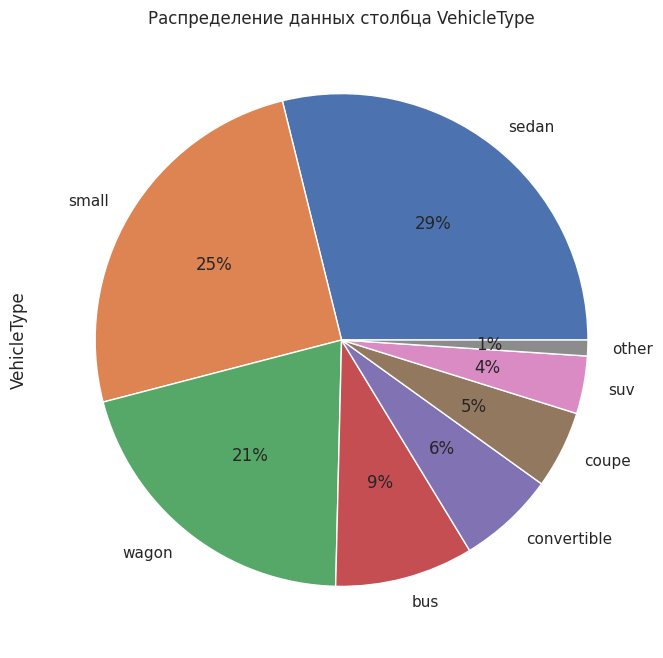

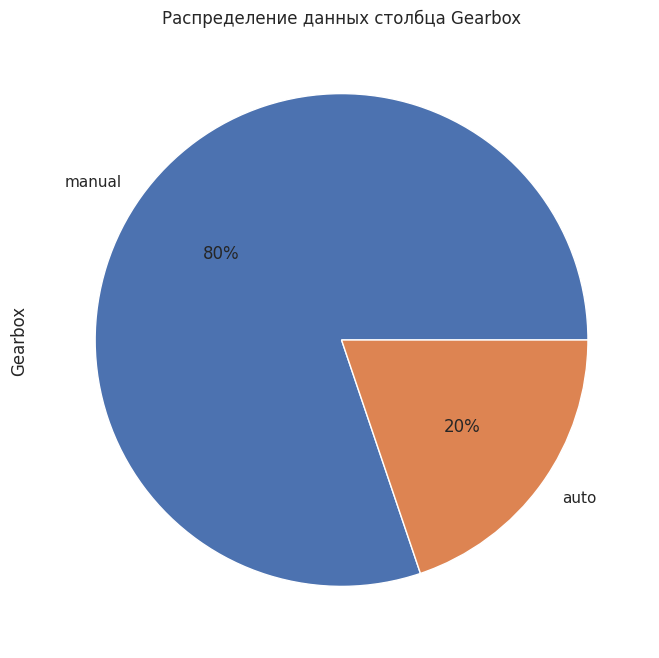

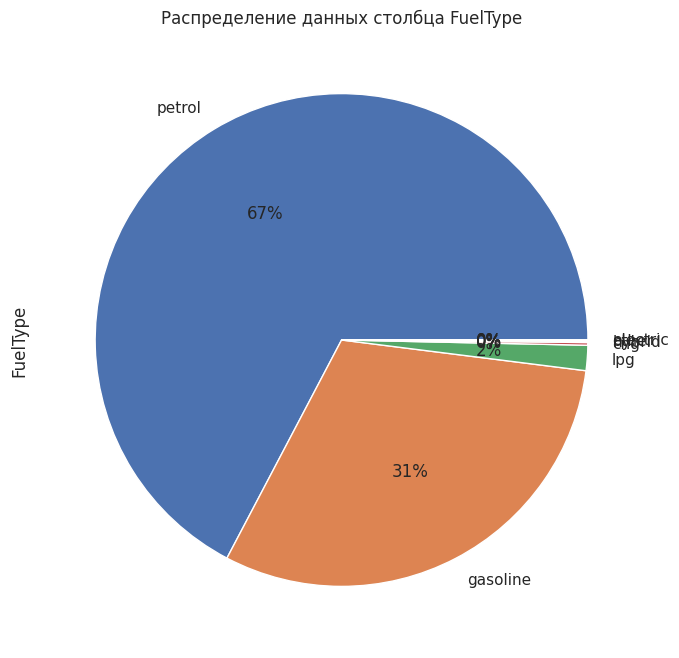

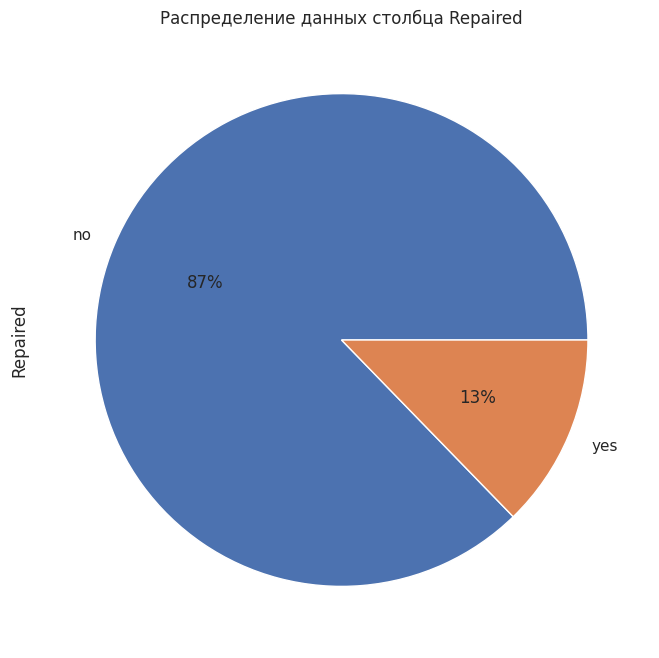

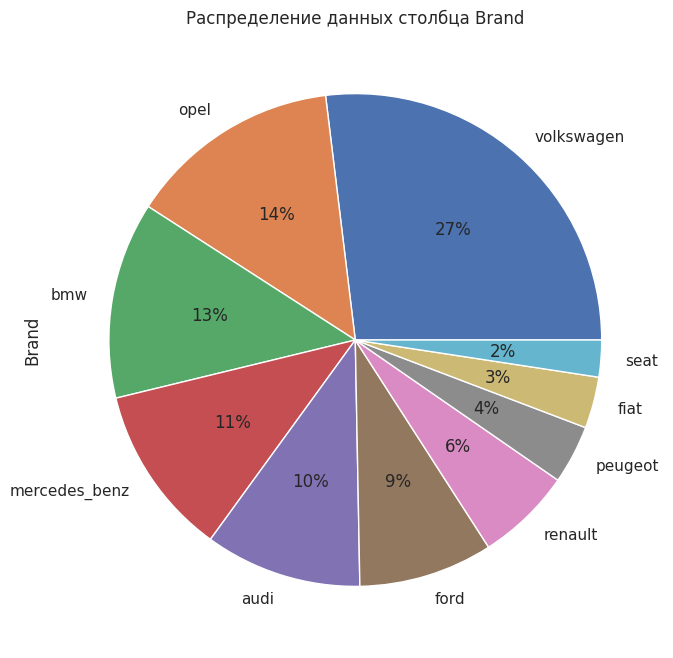

In [19]:
for column in categorial_columns:
    df[column].value_counts()[:10].plot.pie(autopct='%1.0f%%').set_title('Распределение данных столбца {}'.format(column))
    plt.show()

Что из примечательного? Куча нанов. <br>
А также год регистрации больше текущего.  Но есть и 1111 год регистрации, раритет. <br>
Мощность двигателя по 10к л.с. тоже забавна <br>
Нулевой месяц регистрации <br>
Кол-во фоток равное нулю = бесполезный столбец, как и даты создания и последния обновления с почтовыми индексами.

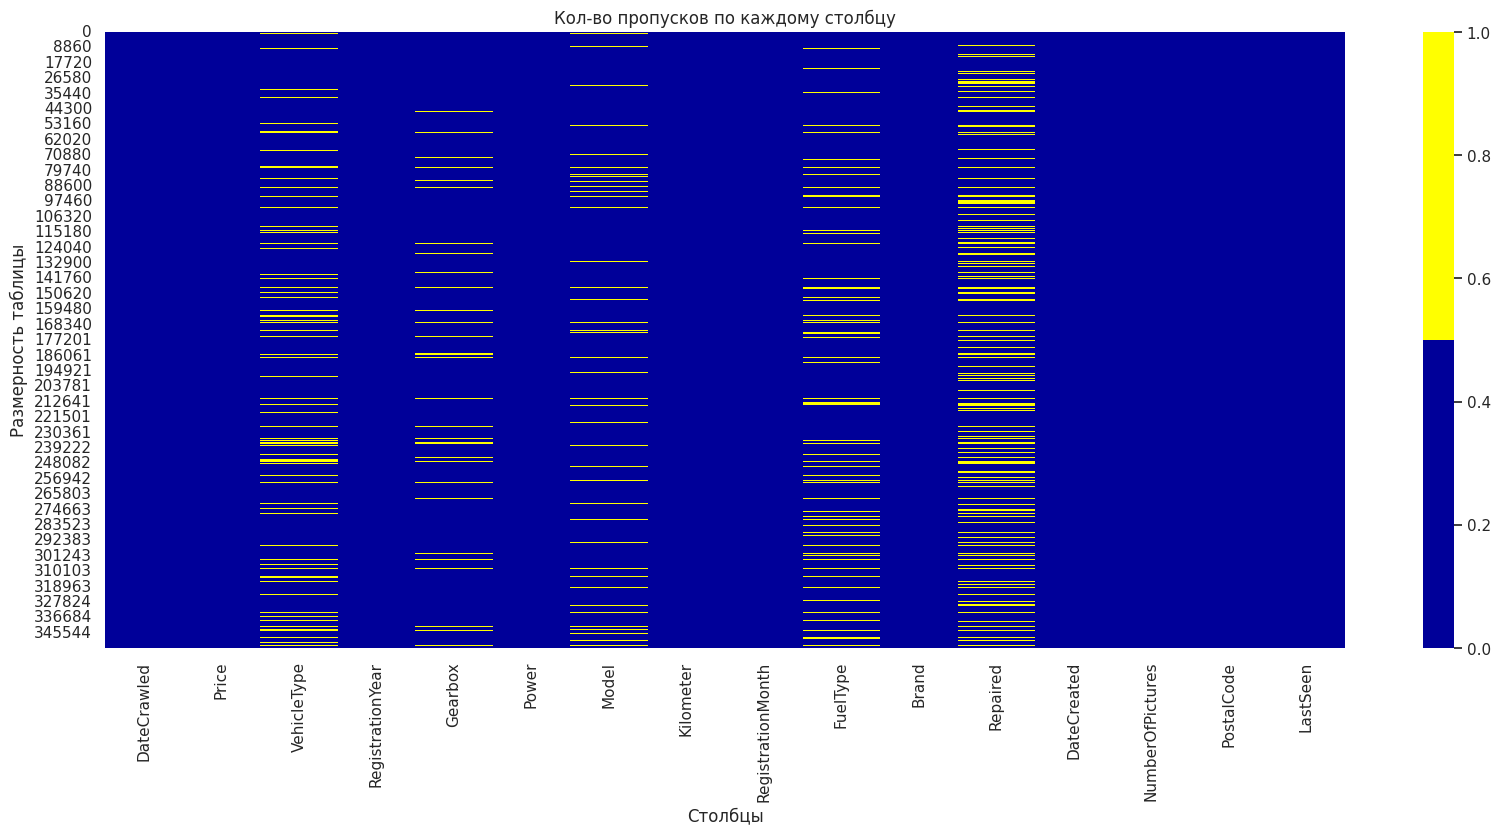

In [20]:
cols = df.columns
colours = ['#000099', '#ffff00']
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours)).set_title('Кол-во пропусков по каждому столбцу')
plt.xlabel('Столбцы')
plt.ylabel('Размерность таблицы')
plt.show()

In [21]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

DateCrawled - 0%
Price - 0%
VehicleType - 11%
RegistrationYear - 0%
Gearbox - 6%
Power - 0%
Model - 6%
Kilometer - 0%
RegistrationMonth - 0%
FuelType - 9%
Brand - 0%
Repaired - 20%
DateCreated - 0%
NumberOfPictures - 0%
PostalCode - 0%
LastSeen - 0%


In [22]:
df['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

created missing indicator for: VehicleType
created missing indicator for: Gearbox
created missing indicator for: Model
created missing indicator for: FuelType
created missing indicator for: Repaired


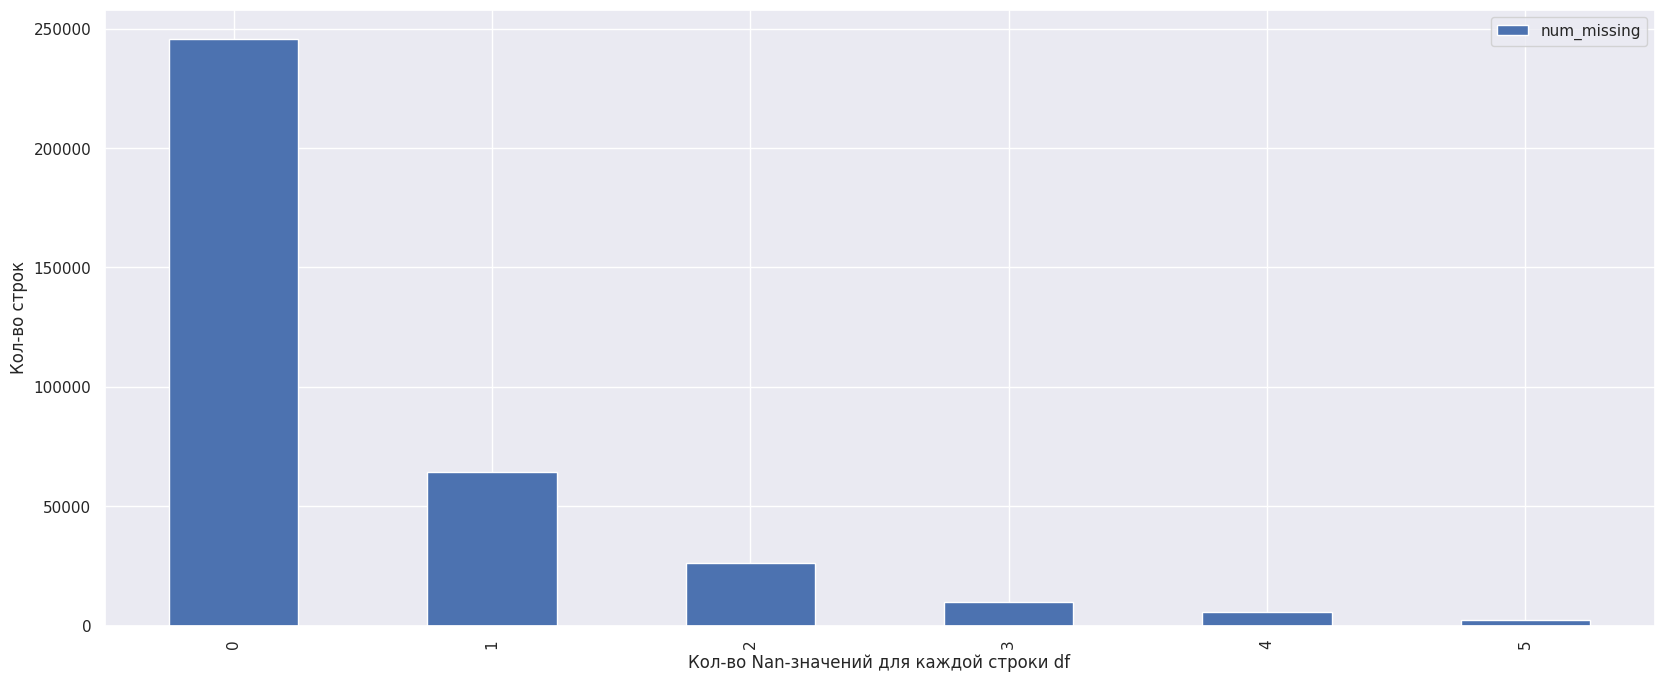

In [23]:
for col in df.columns:
    missing = df[col].isnull()
    num_missing = np.sum(missing)

    if num_missing > 0:
        print('created missing indicator for: {}'.format(col))
        df['{}_ismissing'.format(col)] = missing

# гистограмма на основе подсчитанных нанов в каждой строчке
ismissing_cols = [col for col in df.columns if 'ismissing' in col]
df['num_missing'] = df[ismissing_cols].sum(axis=1)
df['num_missing'].value_counts().reset_index().sort_values(by='index').plot.bar(x='index', y='num_missing')

plt.xlabel('Кол-во Nan-значений для каждой строки df')
plt.ylabel('Кол-во строк')
plt.show()

In [24]:
df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,...,DateCreated,NumberOfPictures,PostalCode,LastSeen,VehicleType_ismissing,Gearbox_ismissing,Model_ismissing,FuelType_ismissing,Repaired_ismissing,num_missing
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,...,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57,True,False,False,False,True,2
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,...,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50,False,False,True,False,False,1
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,...,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46,False,False,False,False,True,1
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,...,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17,False,False,False,False,False,0
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,...,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,...,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49,True,False,False,False,False,1
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,...,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52,True,True,True,True,True,5
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,...,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12,False,False,False,False,False,0
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,...,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26,False,False,False,False,False,0


In [25]:
df.shape

(354365, 22)

In [26]:
df.query('Price == 1')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,...,DateCreated,NumberOfPictures,PostalCode,LastSeen,VehicleType_ismissing,Gearbox_ismissing,Model_ismissing,FuelType_ismissing,Repaired_ismissing,num_missing
59,2016-03-29 15:48:15,1,suv,1994,manual,286,NaN,150000,11,NaN,...,2016-03-29 00:00:00,0,53721,2016-04-06 01:44:38,False,False,True,True,True,3
89,2016-03-28 09:37:01,1,sedan,1995,manual,113,e_klasse,150000,4,gasoline,...,2016-03-28 00:00:00,0,40589,2016-04-06 12:15:54,False,False,False,False,False,0
268,2016-03-12 07:26:49,1,sedan,1990,manual,90,80,70000,6,petrol,...,2016-03-11 00:00:00,0,55122,2016-03-26 23:15:49,False,False,False,False,False,0
408,2016-03-29 18:51:58,1,NaN,2000,NaN,75,golf,90000,3,petrol,...,2016-03-29 00:00:00,0,78588,2016-04-06 04:45:50,True,True,False,False,True,3
901,2016-03-06 00:25:25,1,NaN,1990,manual,0,other,150000,0,NaN,...,2016-03-05 00:00:00,0,65843,2016-04-06 20:19:08,True,False,False,True,True,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353252,2016-03-09 13:48:39,1,coupe,1990,manual,45,polo,150000,0,petrol,...,2016-03-09 00:00:00,0,26160,2016-03-25 07:18:43,False,False,False,False,False,0
353584,2016-03-31 17:56:10,1,NaN,2000,NaN,0,NaN,10000,0,NaN,...,2016-03-31 00:00:00,0,52525,2016-03-31 18:42:13,True,True,True,True,True,5
353682,2016-03-07 13:53:17,1,bus,1999,manual,0,espace,150000,0,petrol,...,2016-03-07 00:00:00,0,57439,2016-03-08 16:51:26,False,False,False,False,True,1
353727,2016-03-20 17:56:59,1,NaN,2000,NaN,0,NaN,150000,0,NaN,...,2016-03-20 00:00:00,0,42329,2016-04-07 00:46:36,True,True,True,True,True,5


Также случайно было обнаружено, что у некоторых машин price = 1 <br>
Их мало, поэтому проще удалить вовсе <br>
Ну и нули есть, их два процента, с ними ничего не сделать, тоже на удаление.

In [27]:
df = df.query('Price > 1')

Далее каждый Nan придется по каждому столбцу менять, можно банально вставлять заглушку 'unknown' <br>
Или же можно под каждую категорию ставить свои значения

In [28]:
pd.DatetimeIndex(df['DateCreated']).year.max()

2016

In [29]:
df.query('RegistrationYear > 2016')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,...,DateCreated,NumberOfPictures,PostalCode,LastSeen,VehicleType_ismissing,Gearbox_ismissing,Model_ismissing,FuelType_ismissing,Repaired_ismissing,num_missing
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,...,2016-03-23 00:00:00,0,49716,2016-03-31 01:16:33,True,False,False,False,False,1
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,...,2016-03-10 00:00:00,0,31139,2016-03-16 09:16:46,True,False,False,True,False,2
48,2016-03-25 14:40:12,7750,NaN,2017,manual,80,golf,100000,1,petrol,...,2016-03-25 00:00:00,0,48499,2016-03-31 21:47:44,True,False,False,False,True,2
51,2016-03-07 18:57:08,2000,NaN,2017,manual,90,punto,150000,11,gasoline,...,2016-03-07 00:00:00,0,66115,2016-03-07 18:57:08,True,False,False,False,False,1
57,2016-03-10 20:53:19,2399,NaN,2018,manual,64,other,125000,3,NaN,...,2016-03-10 00:00:00,0,33397,2016-03-25 10:17:37,True,False,False,True,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354112,2016-03-11 15:49:51,3600,NaN,2017,manual,86,transit,150000,5,gasoline,...,2016-03-11 00:00:00,0,32339,2016-03-12 05:45:02,True,False,False,False,True,2
354140,2016-03-29 16:47:29,1000,NaN,2017,manual,101,a4,150000,9,NaN,...,2016-03-29 00:00:00,0,38315,2016-04-06 02:44:27,True,False,False,True,True,3
354203,2016-03-17 00:56:26,2140,NaN,2018,manual,80,fiesta,150000,6,NaN,...,2016-03-17 00:00:00,0,44866,2016-03-29 15:45:04,True,False,False,True,False,2
354253,2016-03-25 09:37:59,1250,NaN,2018,NaN,0,corsa,150000,0,petrol,...,2016-03-25 00:00:00,0,45527,2016-04-06 07:46:13,True,True,False,False,True,3


In [30]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

DateCrawled - 0%
Price - 0%
VehicleType - 10%
RegistrationYear - 0%
Gearbox - 5%
Power - 0%
Model - 5%
Kilometer - 0%
RegistrationMonth - 0%
FuelType - 8%
Brand - 0%
Repaired - 19%
DateCreated - 0%
NumberOfPictures - 0%
PostalCode - 0%
LastSeen - 0%
VehicleType_ismissing - 0%
Gearbox_ismissing - 0%
Model_ismissing - 0%
FuelType_ismissing - 0%
Repaired_ismissing - 0%
num_missing - 0%


In [31]:
df_for_ml = df[['Price','VehicleType', 'RegistrationYear', 'Gearbox',
                'Power', 'Model', 'Kilometer', 'FuelType', 'Brand', 'Repaired' ]]

In [32]:
colors = sns.color_palette("Paired")
sns.set(rc={'figure.figsize':(20, 8)}, palette=colors)

In [33]:
phik_overview = df_for_ml.phik_matrix(interval_cols= ['Price', 'Power', 'RegistrationYear'])

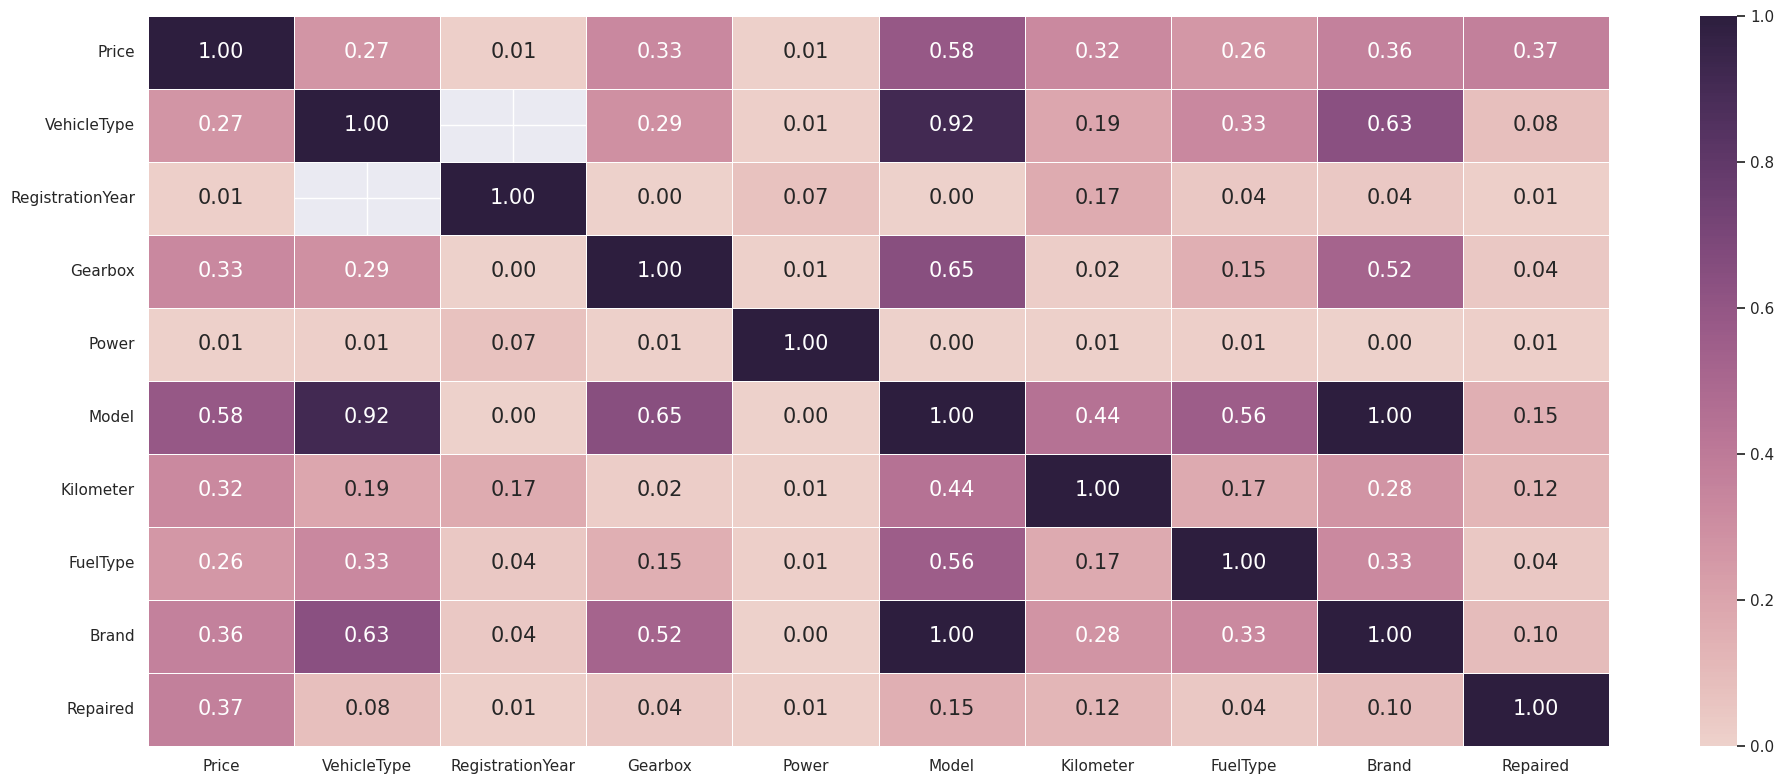

In [34]:
sns.heatmap(phik_overview,
                        vmin=0, vmax=1,
                    annot = True,
                annot_kws = {"size":15},
                cmap=sns.cubehelix_palette(as_cmap=True),
                fmt='.2f',  linewidth=.5)
plt.tight_layout()

По корреляции видим какие столбцы наиболее важны

In [35]:
df_for_ml.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')

In [36]:
cols_for_outer = ['Price', 'Power']

In [37]:
for col in cols_for_outer:
    print(col, df_for_ml[col].quantile(0.985))
    print(col, df_for_ml[col].quantile(0.015))

Price 17999.0
Price 190.0
Power 275.0
Power 0.0


In [38]:
df_for_ml = df_for_ml.query('Price <= 18000 ')
df_for_ml = df_for_ml.query('Price >= 200.0 ')

In [39]:
df_for_ml = df_for_ml.query('Power <= 276 ')
df_for_ml = df_for_ml.query('Power >= 0 ')

In [40]:
df_for_ml = df_for_ml.query('RegistrationYear <= 2016.0 ')
df_for_ml = df_for_ml.query('RegistrationYear >= 1987.0 ')

In [41]:
print("New Shape: ", df_for_ml.shape)

New Shape:  (308498, 10)


Убрали выбросы для нужных числовых столбцов

In [42]:
#df_for_ml['Power'] = df_for_ml['Power'].replace(0, np.nan)
#df_for_ml['Power'] = df_for_ml['Power'].fillna(df_for_ml.groupby('VehicleType')['Power'].transform('median'))

In [43]:
df_for_ml.query('Power == 0')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
32,245,sedan,1994,NaN,0,golf,150000,petrol,volkswagen,no
37,1500,NaN,2016,NaN,0,kangoo,150000,gasoline,renault,no
54,4700,wagon,2005,manual,0,signum,150000,NaN,opel,no
55,550,wagon,1999,manual,0,astra,150000,gasoline,opel,yes
...,...,...,...,...,...,...,...,...,...,...
354335,390,small,1997,auto,0,corsa,100000,petrol,opel,yes
354336,3299,NaN,2005,auto,0,outlander,150000,petrol,mitsubishi,NaN
354346,2600,NaN,2005,auto,0,c_klasse,150000,NaN,mercedes_benz,NaN
354363,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no


In [44]:
#graphs(df_for_ml)

## Обучение моделей

In [45]:
target = df_for_ml['Price']
feature = df_for_ml.drop('Price', axis= 1)

In [46]:
feature_train, feature_test, target_train, target_test = train_test_split(
    feature, target, test_size = 0.2, random_state = RANDOM_STATE)

In [47]:
constant_imputer = SimpleImputer(strategy='constant',fill_value='unknown')
feature_train[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired' ]] = constant_imputer.fit_transform(
    feature_train[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired' ]])

In [48]:
column_transformer = make_column_transformer((StandardScaler(), make_column_selector(dtype_include='number')),
                                             (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
                                              make_column_selector(dtype_include='object')),
                                              remainder='passthrough')

In [49]:
scorer = make_scorer(mean_squared_error, squared= False, greater_is_better = False)

In [50]:
column_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f5ae8463130>),
                                ('ordinalencoder',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f5ae8462e90>)])

### CatBoost

In [51]:
model =  CatBoostRegressor(loss_function= "RMSE", random_state = RANDOM_STATE,
                           verbose=100)

In [52]:
pipeline = make_pipeline(column_transformer, model)
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f5ae8463130>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f5ae8462e90>)])),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x7f5ae8463880>)])

In [53]:
pipeline.named_steps['catboostregressor'].get_all_params

<bound method CatBoost.get_all_params of <catboost.core.CatBoostRegressor object at 0x7f5ae8463880>>

In [54]:
params = {
    'catboostregressor__iterations': range(500,1000,200),
    'catboostregressor__depth': range(2,4),
         }

In [55]:
grid_search = GridSearchCV(pipeline, params, cv=3,n_jobs=-1,
                           scoring=scorer)

In [56]:
%%time
result  = grid_search.fit(feature_train, target_train)

Learning rate set to 0.106505
0:	learn: 3905.8810030	total: 81.2ms	remaining: 1m 12s
100:	learn: 1784.7149570	total: 4.25s	remaining: 33.7s
200:	learn: 1681.7236237	total: 6.8s	remaining: 23.7s
300:	learn: 1634.2370101	total: 9.37s	remaining: 18.7s
400:	learn: 1605.6315488	total: 12s	remaining: 14.9s
500:	learn: 1585.5456784	total: 15.4s	remaining: 12.3s
600:	learn: 1570.5129177	total: 18.3s	remaining: 9.11s
700:	learn: 1557.2446916	total: 20.9s	remaining: 5.92s
800:	learn: 1544.3039989	total: 23.3s	remaining: 2.88s
899:	learn: 1534.4819867	total: 25.7s	remaining: 0us
CPU times: user 49 s, sys: 1.53 s, total: 50.6 s
Wall time: 4min 59s


In [57]:
result.best_params_

{'catboostregressor__depth': 3, 'catboostregressor__iterations': 900}

In [58]:
cat = -1 * result.best_score_
cat

1549.706189905397

In [59]:
best_cat_model =  CatBoostRegressor(loss_function= "RMSE", random_state = RANDOM_STATE,
                           verbose=100)
pipeline_with_best_cat_model = make_pipeline(column_transformer, best_cat_model)

In [60]:
start_cat = time()
pipeline_with_best_cat_model.fit(feature_train, target_train)
end_cat = time()

Learning rate set to 0.097762
0:	learn: 3884.6166133	total: 61.7ms	remaining: 1m 1s
100:	learn: 1615.5194893	total: 4.49s	remaining: 40s
200:	learn: 1530.3361681	total: 7.75s	remaining: 30.8s
300:	learn: 1489.8448487	total: 11.3s	remaining: 26.2s
400:	learn: 1462.1468553	total: 16.5s	remaining: 24.6s
500:	learn: 1441.7103896	total: 20s	remaining: 19.9s
600:	learn: 1424.8131330	total: 23.4s	remaining: 15.5s
700:	learn: 1411.0185242	total: 28.5s	remaining: 12.2s
800:	learn: 1398.3646819	total: 32s	remaining: 7.94s
900:	learn: 1387.6633125	total: 35.5s	remaining: 3.9s
999:	learn: 1378.6273627	total: 39.8s	remaining: 0us


In [61]:
model_time_cat = (end_cat-start_cat)/60
model_time_cat

0.6989296078681946

In [62]:
start_cat_predict = time()
pipeline_with_best_cat_model.predict(feature_train)
end_cat_predict = time()

In [63]:
model_time_cat_predict = (end_cat_predict-start_cat_predict)/60
model_time_cat_predict

0.03371546665827433

Т.к. мои подобранные гиперпараметры гридсерчем выдают результат хуже автоматически выставленных самим catboost, то было решено оставить дефолт модель.

### LGBM

In [64]:
lgbm = LGBMRegressor(n_jobs = -1, random_state= RANDOM_STATE)

In [65]:
pipeline_lgbm = make_pipeline(column_transformer, lgbm)
pipeline_lgbm

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f5ae8463130>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f5ae8462e90>)])),
                ('lgbmregressor',
                 LGBMRegressor(n_jobs=-1, random_state=12345))])

In [66]:
pipeline_lgbm.named_steps

{'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f5ae8463130>),
                                 ('ordinalencoder',
                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                 unknown_value=-1),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f5ae8462e90>)]),
 'lgbmregressor': LGBMRegressor(n_jobs=-1, random_state=12345)}

In [67]:
param_grid =    { 'lgbmregressor__learning_rate': [0.1, 0.01],
      'lgbmregressor__n_estimators': [ 150],
      'lgbmregressor__max_depth': [6],
      'lgbmregressor__subsample': [0.7, 0.8],
      'lgbmregressor__min_child_samples': [5, 10]
        }

model = GridSearchCV(pipeline_lgbm,
                       param_grid=param_grid,
                       cv=3,
                       n_jobs=-1,
                       scoring=scorer)

model.fit(feature_train, target_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 562
[LightGBM] [Info] Number of data points in the train set: 246798, number of used features: 9
[LightGBM] [Info] Start training from score 4390.361911


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f5ae8463130>),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         <sklearn.compose._column_t...
                                       ('lgbmregressor',
                                        LGBMRegressor(n_jobs=-1,
                                                      random_state=12345))]),
             n_jobs=-1,
             param_grid={'lgbmregressor__learning_rate': [0.1, 0.01],
                         'lgbmregressor__max_depth': [6],
                         'lgbmregressor__min_child_samples': [5, 10],
                         'lgbmregressor__n_estimators': [150],
                         'lgbmregressor__subsample': [0.7, 0.8]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False))

In [68]:
lgbm = -1 * model.best_score_

Зафиксируем лучшие гиперпараметры для лгбм

In [69]:
model.best_params_

{'lgbmregressor__learning_rate': 0.1,
 'lgbmregressor__max_depth': 6,
 'lgbmregressor__min_child_samples': 10,
 'lgbmregressor__n_estimators': 150,
 'lgbmregressor__subsample': 0.7}

In [70]:
lgbm_best = LGBMRegressor(n_jobs = -1, objective='regression',
          learning_rate =  0.1,
 max_depth= 6,
 min_child_samples=10,
 n_estimators= 150,
 subsample= 0.7, random_state= RANDOM_STATE)

In [71]:
pipeline_lgbm = make_pipeline(column_transformer, lgbm_best)
pipeline_lgbm

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f5ae8463130>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f5ae8462e90>)])),
                ('lgbmregressor',
                 LGBMRegressor(max_depth=6, min_child_samples=10,
                               n_estimators=150, n_jobs=-1,
                               objective='regression', random_state=12345,
                               subsample=0.7))])

In [72]:
start_lgbm = time()
pipeline_lgbm.fit(feature_train, target_train)
pipeline_lgbm.predict(feature_train)
end_lgbm = time()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 562
[LightGBM] [Info] Number of data points in the train set: 246798, number of used features: 9
[LightGBM] [Info] Start training from score 4390.361911
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [73]:
model_time_lgbm  = (end_lgbm -start_lgbm )/60
model_time_lgbm

0.08008766571680705

In [74]:
start_lgbm_predict = time()
pipeline_lgbm.predict(feature_train)
end_lgbm_predict = time()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [75]:
model_time_lgbm_predict  = (end_lgbm_predict -start_lgbm_predict )/60
model_time_lgbm_predict

0.034321908156077066

Результат с параметрами гридсерча вышел лучше дефолтного.

### Random Forest Regression

In [76]:
rfg = RandomForestRegressor(random_state= RANDOM_STATE, max_depth= None)

In [77]:
pipeline_rfg = make_pipeline(column_transformer, rfg)
pipeline_rfg

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f5ae8463130>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f5ae8462e90>)])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=12345))])

In [78]:
params_for_rfg = { 'randomforestregressor__max_depth': [None, 2,3]}

In [79]:
pipeline_rfg = make_pipeline(column_transformer, rfg)

In [80]:
model = GridSearchCV(pipeline_rfg,
                       param_grid=params_for_rfg,
                       cv=3,
                       n_jobs=-1,
                       scoring=scorer)

In [81]:
model.fit(feature_train, target_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f5ae8463130>),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f5ae8462e90>)])),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=12345))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [None, 2, 3]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False))

In [82]:
rfg = -1 * model.best_score_
rfg

1461.492027559737

In [83]:
start_rfg = time()
pipeline_rfg.fit(feature_train, target_train)
end_rfg = time()

In [84]:
model_time_rfg  = (end_rfg -start_rfg )/60
model_time_rfg

1.3440226912498474

In [85]:
start_rfg_predict = time()
predicted = pipeline_rfg.predict(feature_train)
end_rfg_predict = time()

In [86]:
model_time_rfg_predict  = (end_rfg_predict -start_rfg_predict )/60
model_time_rfg_predict

0.23076742490132648

GreedSearch определил, что max_depth = None, лучший показатель, что и является дефолтным вариантом.  <br>
Более глубоко подбирать гиперпараметры особо смысла не имеет потому, что Случайный лес слишком медленно обучается.

## Анализ моделей

In [87]:
dummy = DummyRegressor(strategy="mean" )
dummy.fit(feature_train, target_train)

DummyRegressor()

In [88]:
preds = dummy.predict(feature_test)
rmse_for_dummy =  mean_squared_error(preds, target_test, squared= False)
rmse_for_dummy

4133.3589100389845

Все модели успешно обошли dummy-модель

In [89]:
d = {'result (rmse)': [cat, lgbm ,rfg],
     'time_fit': [model_time_cat , model_time_lgbm , model_time_rfg],
    'time_predict': [model_time_cat_predict,  model_time_lgbm_predict, model_time_rfg_predict]}
data = pd.DataFrame(data=d, index=['CatBoost','LGBM', 'RandomForestRegression'])

In [90]:
data

,result (rmse),time_fit,time_predict
CatBoost,1549.706190,0.698930,0.033715
LGBM,1501.117534,0.080088,0.034322
RandomForestRegression,1461.492028,1.344023,0.230767


Модель catboost я выберу для тестовой проверки, она мне более симпатизирует и я знаю, что у нее будут результаты лучше остальных.

In [91]:
preds_cat_boost = pipeline_with_best_cat_model.predict(feature_test)
rmse_test_cat_boost = mean_squared_error(preds_cat_boost, target_test, squared= False)
rmse_test_cat_boost

1588.141456692181

Результат RMSE в 1588.1 на тестовой выборке полностью удовлетворяет условия задачи.